In [44]:
import pandas as pd

# =========================
# CONFIGURATION
# =========================
EXCEL_FILE = "eventzella_schema_general.xlsx"
DATE_KEYWORDS = ["date", "time"]

# =========================
# LOAD ALL SHEETS
# =========================
sheets = pd.read_excel(EXCEL_FILE, sheet_name=None)
print(f"Loaded {len(sheets)} tables")

# =========================
# FUNCTIONS
# =========================

def completeness_score(df):
    total = df.size
    non_null = df.notnull().sum().sum()
    return round((non_null / total) * 100, 2)


def uniqueness_score(df):
    if df.empty:
        return 100.0
    duplicates = df.duplicated().sum()
    return round(((len(df) - duplicates) / len(df)) * 100, 2)


def validity_score_dates(df):
    date_columns = [c for c in df.columns if any(k in c.lower() for k in DATE_KEYWORDS)]
    if not date_columns:
        return 100.0

    invalid = 0
    total = 0

    for col in date_columns:
        parsed = pd.to_datetime(df[col], errors="coerce")
        invalid += parsed.isnull().sum()
        total += len(parsed)

    if total == 0:
        return 100.0

    return round(((total - invalid) / total) * 100, 2)


# =========================
# DATA QUALITY CALCULATION
# =========================
report_rows = []

for table_name, df in sheets.items():
    completeness = completeness_score(df)
    uniqueness = uniqueness_score(df)
    validity = validity_score_dates(df)

    overall = round((completeness + uniqueness + validity) / 3, 2)

    report_rows.append({
        "Table": table_name,
        "Completeness (%)": completeness,
        "Uniqueness (%)": uniqueness,
        "Validity (%)": validity,
        "Overall Quality (%)": overall
    })

# =========================
# FINAL REPORT
# =========================
dq_report = pd.DataFrame(report_rows)

print("\n=== DATA QUALITY REPORT ===")
print(dq_report)

# =========================
# GLOBAL SCORE
# =========================
global_score = round(dq_report["Overall Quality (%)"].mean(), 2)
print(f"\nGLOBAL DATA QUALITY SCORE: {global_score}%")


Loaded 15 tables

=== DATA QUALITY REPORT ===
              Table  Completeness (%)  Uniqueness (%)  Validity (%)  \
0       BENEFICIARY             95.45           100.0         100.0   
1          PROVIDER             98.60           100.0         100.0   
2          CATEGORY            100.00           100.0         100.0   
3       SUBCATEGORY            100.00           100.0         100.0   
4           SERVICE             96.25           100.0         100.0   
5             EVENT             98.68           100.0         100.0   
6       RESERVATION            100.00           100.0         100.0   
7        EVALUATION             97.99           100.0         100.0   
8         COMPLAINT             99.99           100.0         100.0   
9          VISITORS            100.00           100.0         100.0   
10  MARKETING_SPEND            100.00           100.0         100.0   
11       competitor             97.22           100.0         100.0   
12        locations            

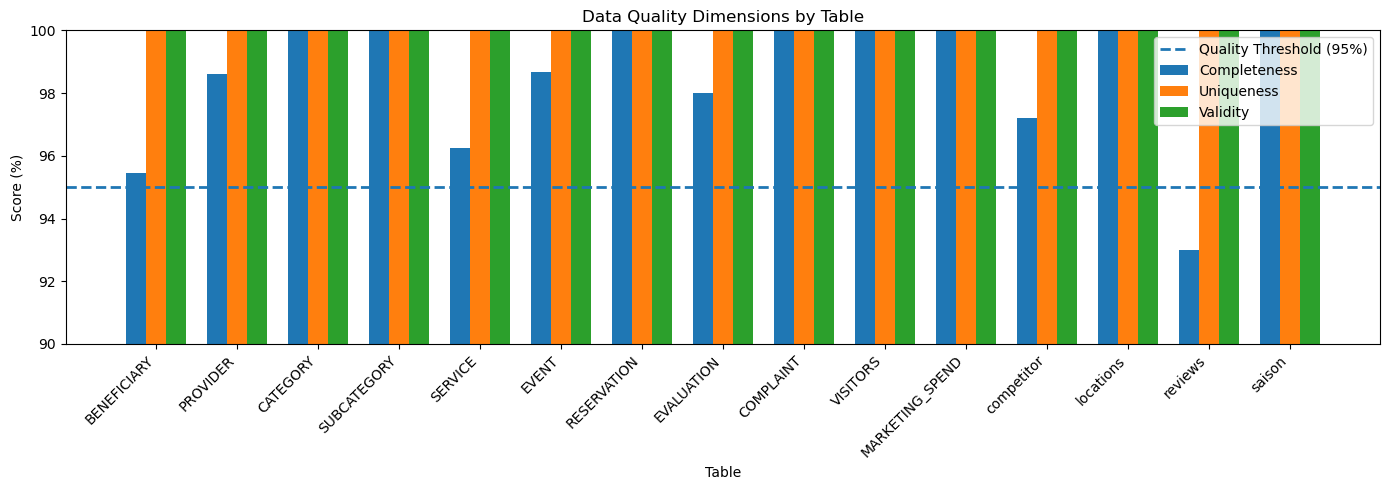

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Nettoyage
dq_clean = dq_report.dropna(subset=["Completeness (%)"])

tables = dq_clean["Table"]
x = np.arange(len(tables))
width = 0.25

plt.figure(figsize=(14, 5))

plt.bar(x - width, dq_clean["Completeness (%)"], width, label="Completeness")
plt.bar(x, dq_clean["Uniqueness (%)"], width, label="Uniqueness")
plt.bar(x + width, dq_clean["Validity (%)"], width, label="Validity")

# Seuil qualité
plt.axhline(y=95, linestyle="--", linewidth=2, label="Quality Threshold (95%)")

plt.title("Data Quality Dimensions by Table")
plt.xlabel("Table")
plt.ylabel("Score (%)")
plt.xticks(x, tables, rotation=45, ha="right")
plt.ylim(90, 100)
plt.legend()
plt.tight_layout()
plt.show()


All tables demonstrate high levels of completeness, uniqueness, and validity.
Most scores exceed the 95% quality threshold, confirming strong data integrity and consistency across the system.

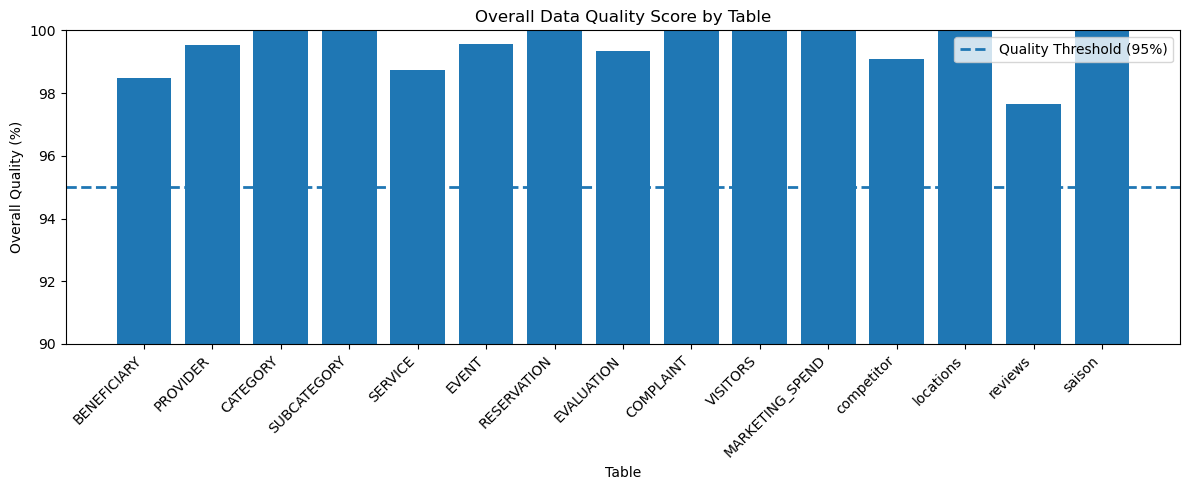

In [47]:
plt.figure(figsize=(12, 5))

plt.bar(
    dq_clean["Table"],
    dq_clean["Overall Quality (%)"]
)

# Seuil global
plt.axhline(y=95, linestyle="--", linewidth=2, label="Quality Threshold (95%)")

plt.title("Overall Data Quality Score by Table")
plt.xlabel("Table")
plt.ylabel("Overall Quality (%)")
plt.xticks(rotation=45, ha="right")
plt.ylim(90, 100)
plt.legend()
plt.tight_layout()
plt.show()



The overall data quality scores are consistently high across all tables, with an average quality score above 99%.
This confirms that the dataset is reliable, well-structured, and suitable for analytical and decision-making purposes.


In [60]:

rows = []

for table, missing in missing_details.items():
    for col, pct in missing.items():
        rows.append({
            "Table": table,
            "Column": col,
            "Missing (%)": pct
        })

missing_df = pd.DataFrame(rows)
missing_df.sort_values(["Table", "Missing (%)"], ascending=[True, False], inplace=True)

missing_df


,Table,Column,Missing (%)
1,BENEFICIARY,email,8.00
2,BENEFICIARY,phone,7.78
0,BENEFICIARY,last_name,6.96
8,COMPLAINT,description,0.04
7,EVALUATION,comment,8.05
6,EVENT,budget,7.90
3,PROVIDER,email,8.38
5,SERVICE,title,13.96
4,SERVICE,price,8.56
10,reviews,Description,34.15


#FR

<h3>🟦 Table : BENEFICIARY</h3>
🔹 Colonnes concernées

email (8.00 %)

phone (7.78 %)

last_name (6.96 %)

🔧 Méthode d’imputation

Remplacement par la valeur "Unknown"

📝 Justification

Ces champs correspondent à des informations personnelles facultatives qui peuvent ne pas être fournies par le bénéficiaire.
L’absence de ces données ne bloque pas le processus métier principal.

L’utilisation de la valeur "Unknown" permet :

de préserver l’intégrité des données,

d’éviter des imputations artificielles ou erronées,

de maintenir une distinction claire entre données réelles et données manquantes.

<h3>🟦 Table : PROVIDER</h3>
🔹 Colonne concernée

email (8.38 %)

🔧 Méthode d’imputation

Remplacement par "Unknown"

📝 Justification

L’adresse email du prestataire n’est pas toujours obligatoire ou disponible.
L’imputation par "Unknown" est cohérente d’un point de vue métier et évite l’introduction de fausses adresses email.

<h3>🟦 Table : SERVICE</h3>
🔹 Colonne : price (8.56 %)
🔧 Méthode d’imputation

Imputation par prédiction à l’aide d’un Random Forest Regressor

📝 Justification de la méthode

Le prix d’un service dépend fortement :

de la sous-catégorie,

du titre du service,

de la complexité et de la valeur perçue.

Une imputation par moyenne globale serait peu représentative et introduirait un biais.

🧠 Justification du choix du modèle

Le modèle Random Forest a été retenu car il :

capte les relations non linéaires,

est robuste aux valeurs aberrantes,

gère efficacement les variables catégorielles encodées,

ne nécessite pas d’hypothèses fortes sur la distribution des données.

🔹 Colonne : title (13.96 %)
🔧 Méthode d’imputation

Prédiction du titre à partir de la description textuelle

🧠 Modèle utilisé

TF-IDF + Régression Logistique

📝 Justification

La description contient une information sémantique riche (type d’événement, activité, public cible).
Cette approche permet une imputation cohérente et alignée avec le contenu réel du service.

<h3>🟦 Table : EVENT</h3>
🔹 Colonne : budget (7.90 %)
🔧 Méthode d’imputation

MissForest (imputation basée sur Random Forest)

📝 Justification

Bien qu’aucune corrélation linéaire forte n’ait été observée entre les variables, MissForest :

détecte des relations non linéaires,

exploite des interactions complexes,

est robuste aux données hétérogènes.

Cette méthode est particulièrement adaptée aux données événementielles complexes.

<h3>🟦 Table : EVALUATION</h3>
🔹 Colonne concernée

comment (8.05 %)

🔧 Méthode d’imputation

Aucune imputation (valeurs laissées vides)

📝 Justification

Le commentaire est facultatif :
un utilisateur peut attribuer une note sans laisser de commentaire textuel.
Toute imputation artificielle introduirait un biais sémantique.

<h3>🟦 Table : COMPLAINT</h3>
🔹 Colonne concernée

description (0.04 %)

🔧 Méthode d’imputation

Aucune imputation

📝 Justification

Une plainte peut être enregistrée uniquement avec un sujet ou un statut.
Laisser ce champ vide respecte la logique métier et garantit l’authenticité des données.

<h3>🟦 Table : REVIEWS</h3>
🔹 Colonne : title (0.98 %)
🔧 Méthode d’imputation

Remplacement par la modalité la plus fréquente (mode)

📝 Justification

Le taux de valeurs manquantes est très faible.
Cette méthode est :

rapide,

stable,

peu biaisée dans ce contexte.

🔹 Colonne : description (34.15 %)
🔧 Méthode d’imputation

MICE (Multivariate Imputation by Chained Equations)

📝 Justification

Le pourcentage de valeurs manquantes est élevé.
Des corrélations ont été identifiées :

description_length ↔ title_length (0.32)

description_length ↔ rating_review (-0.87)

MICE permet une imputation multivariée réaliste en tenant compte de ces relations, avec un risque de biais faible après amputation.

<h3>🟦 Table : COMPETITORS</h3>
🔹 Colonne concernée

starting_price (5 valeurs manquantes)

🔧 Méthode d’imputation

KNN (K-Nearest Neighbors)

📝 Justification

Des corrélations, bien que modérées, existent entre starting_price et :

rating_stars,

value_money (≈ 0.17).

KNN permet d’estimer les prix manquants à partir de concurrents similaires, garantissant une imputation réaliste et cohérente métier..

#EN

<h3> 1️⃣ Table: BENEFICIARY </h3>
Affected Columns

email (8.00%)

phone (7.78%)

last_name (6.96%)

Imputation Method

Replacement with the value "Unknown"

Justification

These attributes are optional personal information that may not be provided by beneficiaries.
Their absence does not affect the core business processes.

Using "Unknown":

preserves data integrity,

avoids artificial or incorrect imputations,

maintains a clear distinction between real and missing data.

<h3>2️⃣ Table: PROVIDER</h3>
Affected Column

email (8.38%)

Imputation Method

Replacement with "Unknown"

Justification

Provider email addresses are not always mandatory or available.
Imputing with "Unknown" is business-consistent and prevents the creation of fake email values.

<h3>3️⃣ Table: SERVICE</h3>
🔹 Column: price (8.56%)
Imputation Method

Predictive imputation using a Random Forest Regressor

Method Justification

Service pricing strongly depends on:

the service subcategory,

the service title,

the perceived value and complexity.

A global mean imputation would be poorly representative and introduce bias.

Model Justification

Random Forest was selected because it:

captures non-linear relationships,

is robust to outliers,

handles encoded categorical variables efficiently,

requires no strong distributional assumptions.

🔹 Column: title (13.96%)
Imputation Method

Title prediction based on service description

Model Used

TF-IDF + Logistic Regression

Justification

Service descriptions contain rich semantic information (event type, activity, target audience).
This approach ensures a coherent and content-aligned title reconstruction.

<h3>4️⃣ Table: EVENT</h3>
🔹 Column: budget (7.90%)
Imputation Method

MissForest (Random Forest–based imputation)

Justification

Although no strong linear correlations were observed, MissForest:

detects non-linear patterns,

captures complex interactions,

is robust to heterogeneous data.

This makes it well suited for complex event-related datasets.

<h3>5️⃣ Table: EVALUATION</h3>
Affected Column

comment (8.05%)

Imputation Method

No imputation (left empty)

Justification

Comments are optional.
Users may provide only a rating without textual feedback.
Artificially imputing comments would introduce semantic bias.

<h3>6️⃣ Table: COMPLAINT</h3<
Affected Column

description (0.04%)

Imputation Method

No imputation

Justification

A complaint can be submitted with only a subject or status.
Leaving this field empty respects business logic and data authenticity.

<h3>7️⃣ Table: REVIEWS</h3>
🔹 Column: title (0.98%)
Imputation Method

Replacement with the most frequent value (mode)

Justification

The missing rate is very low.
Mode imputation is:

fast,

stable,

minimally biased in this context.

🔹 Column: description (34.15%)
Imputation Method

MICE (Multivariate Imputation by Chained Equations)

Justification

The missing rate is high.
Detected correlations include:

description_length ↔ title_length (0.32)

description_length ↔ rating_review (-0.87)

MICE enables realistic multivariate imputation by leveraging these relationships, with a low risk of bias after amputation.

<h3>8️⃣ Table: COMPETITORS</h3>
Affected Column

starting_price (5 missing values out of 20 × 9 dataset)

Imputation Method

KNN (K-Nearest Neighbors)

Justification

Moderate correlations exist between starting_price and:

rating_stars,

value_money (≈ 0.17).

KNN estimates missing prices using similar competitors, ensuring a realistic and business-consistent imputation